In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.9 MB/s eta 0:00:00


In [16]:
import torch
from torch.utils.data import DataLoader
import tqdm
from datasets import load_dataset
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import pickle
from sklearn.metrics import accuracy_score
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct


In [3]:

dataset = load_dataset("Maysee/tiny-imagenet")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:

train = dataset["train"]
val = dataset["valid"]

In [5]:
class TinyImageNetDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image = self.dataset[index]["image"]
        label = self.dataset[index]["label"]

        if self.transform:
            image = self.transform(image)
        # if grayscale, convert to 3-channel
        if image.size(0) == 1:
            image = image.repeat(3, 1, 1)

        if self.transform:
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            
        label = torch.tensor(label)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [6]:

transform = transforms.Compose([
    # transforms.Resize(25),
    # transforms.CenterCrop(64),
    transforms.ToTensor(),
   
])

In [7]:
train_dataset = TinyImageNetDataset(train,transform)
val_dataset = TinyImageNetDataset(val,transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
val_dataset

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [8]:
class Resnet50TinyImageNet(nn.Module):
  # load the pretrained ResNet50 model
  # freeze the weights of the pre-trained layers
  # modify the last layer to output 200 classes
    def __init__(self):
        super(Resnet50TinyImageNet, self).__init__()
        self.model = resnet50()
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 200)
    
    def forward(self, x):
        return self.model(x)
    
    def train(self, train_loader, criterion, optimizer, num_epochs=10):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        
        for epoch in range(num_epochs):
            train_loss = 0.0
            train_acc = 0.0
            
            self.model.train()
            for image, label in tqdm.tqdm(train_loader):
                image = image.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()
                
                outputs = self.model(image)
                loss = criterion(outputs, label)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * image.size(0)
                _, prediction = torch.max(outputs, 1)
                train_acc += torch.sum(prediction == label.data)
            
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_acc / len(train_loader.dataset)

            self.model.eval()
            val_acc = 0.0

            for image,label in val_loader:
              image = image.to(device)
              labal = label.to(device)
              outputs = self.model(image)
              _, prediction = torch.max(outputs,1)
              val_acc += torch.sum(prediction == label.data)

            val_acc = val_acc/len(val_loader.dataset)




            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}\tValidation Accuracy: {:.6f}'.format(
                epoch+1, train_loss, train_acc,val_acc))
            

    def test(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model.eval()
        predictions = []
        true = []

        for image, label in tqdm.tqdm(test_loader):
            image = image.to(device)
            label = label.to(device)

            outputs = self.model(image)
            _, prediction = torch.max(outputs, 1)
            predictions.append(prediction)
            true.append(label.data)

        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)

        print("Accuracy: ", accuracy_score(true.cpu(), predictions.cpu()))

        return predictions


In [9]:
torch.cuda.is_available()

True

In [ ]:
model = Resnet50TinyImageNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)



In [12]:


model = Resnet50TinyImageNet()

# setting to model to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(r'/content/drive/MyDrive/Projects and Works/res3.pth', map_location=device))

model

Resnet50TinyImageNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
pred = model.test(val_loader)

100%|██████████| 157/157 [00:19<00:00,  7.99it/s]


Accuracy:  0.7043


In [ ]:
acc = 0
correct_preds = []
for i in range(10000):
  out = model(val_dataset[i][0].unsqueeze(0).to(device))
  out = F.softmax(out)

  _, pred = torch.max(out, 1)
  
  #compare pred with val_dataset[i][1]
  if pred == val_dataset[i][1]:
      correct_preds.append(i)
      acc += 1

print(acc/10000)


<ipython-input-13-be25cda18fb7>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


KeyboardInterrupt: ignored

In [ ]:
print(correct_preds)
print(len(correct_preds))

[3058, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3658, 3661, 3662, 3663, 3664, 3665, 3666, 3668, 3670, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3843, 3844, 4717, 6108, 6111, 6112, 6118, 6119, 6121, 6123, 6127, 6131, 6138, 6141, 6148, 7256, 7287, 7417, 7440, 7441, 7444, 8214, 9838, 9875]
67


In [ ]:
SIMBA_single_unt(val_dataset[0][0].cuda(),val_dataset[0][1].cuda(),model.cuda())

In [ ]:
def SIMBA_single_unt(x,y,model,epsilon=0.2,num_iters = 10000):
  n_dims = x.view(1,-1).size(1)
  perm = torch.randperm(n_dims)
  x = x.unsqueeze(0)
  x_probs = F.softmax(model(x))
  def_prob = x_probs[0][y]


  for i in range(num_iters):
    delta = torch.zeros(n_dims).to(device)
    delta[perm[i]] = epsilon
    add_vec = x + delta.view(x.size())
    # new_prob = F.softmax(model(add_vec))[0][y]
    probs = F.softmax(model(add_vec))
    new_probs = probs[0][y]
    ad_prob, ad_pred = torch.max(ad_out, 1)

    if ad_probs > new_probs:
      break

    if new_prob < def_prob:
      x = add_vec
      def_prob = new_prob
    else:
      x = x - delta.view(x.size())
      def_prob = F.softmax(model(add_vec))[0][y]
  
  return x.squeeze(), i, ad_pred

# def SIMBA_single_tar(x,y,model,epsilon=0.2,num_iters=10000):
#   # targetted adverse attack function
#   n_dims - x.view(1,-1).size(1)
#   perm = torch.randperm(n_dims)
#   x = x.unsqueeze(0)
#   x_probs = F.softmax(model(x))
#   def_prob = x_probs[0][y]

#   for i in range(num_iters):
#     delta = torch.zeros(n_dims)










# SIMBA for Untargeted

In [41]:
def SIMBA_single_unt(x,y,model,epsilon=0.2,num_iters = 10000):
  n_dims = x.view(1,-1).size(1)
  perm = torch.randperm(n_dims)
  x = x.unsqueeze(0)
  x_probs = F.softmax(model(x))
  def_prob = x_probs[0][y]


  for i in range(num_iters):
    delta = torch.zeros(n_dims).to(device)
    delta[perm[i]] = epsilon
    add_vec = x + delta.view(x.size())
    probs = F.softmax(model(add_vec))
    new_prob = probs[0][y]


    if new_prob < def_prob:
      x = add_vec
      def_prob = new_prob
    else:
      x = x - delta.view(x.size())
      # def_prob = F.softmax(model(x))[0][y]
      probs = F.softmax(model(x))
      def_prob = probs[0][y]

    ad_prob, ad_pred = torch.max(probs, 1)


    if ad_pred[0].item()!=y:
      break

  return x.squeeze(), i, ad_pred[0].item(),x_probs[0][y],probs[0][y],x_probs[0][ad_pred],ad_prob,y
  # adv image, number of iterations, initial prob of original class, final prob of original class, initial prob of adverse class, final prob of adverse class

In [70]:
out,out1,out2,out3,out4,out5,out6,out7 = SIMBA_single_unt(val_dataset[5024][0].cuda(),val_dataset[5024][1].cuda(),model.cuda())

<ipython-input-67-9e46aaf655ba>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x))
<ipython-input-67-9e46aaf655ba>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec))
<ipython-input-67-9e46aaf655ba>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(x))


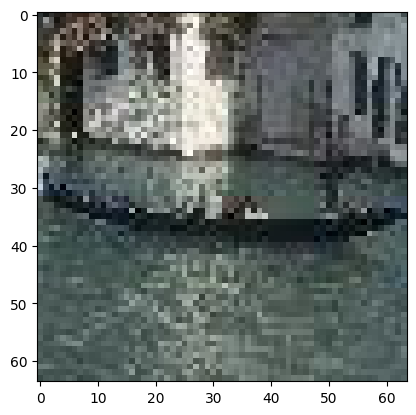

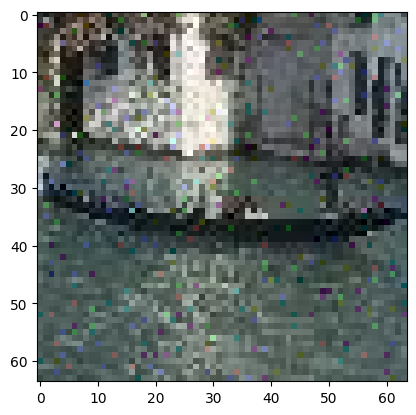

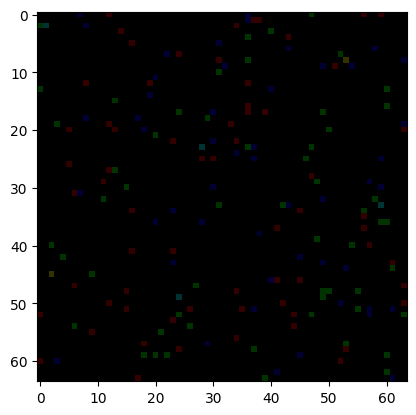

94
tensor(100, device='cuda:0')


In [71]:
plt.imshow(val_dataset[5024][0].permute(1,2,0))
plt.show()
out = out.to('cpu')
plt.imshow(out.permute(1,2,0))
plt.show()
# print(iter)
plt.imshow((val_dataset[5024][0]-out).permute(1,2,0))
plt.show()
print(out2)
print(out7)

<ipython-input-41-9e46aaf655ba>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x))
<ipython-input-41-9e46aaf655ba>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec))
<ipython-input-41-9e46aaf655ba>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(x))


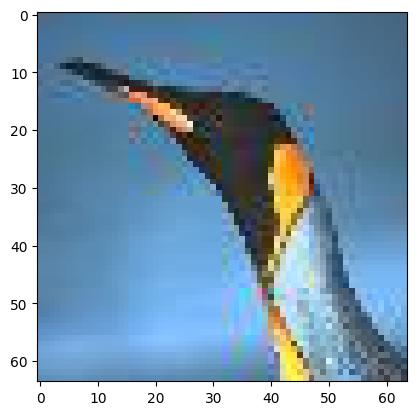

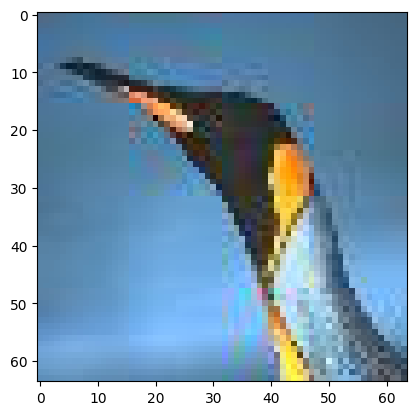

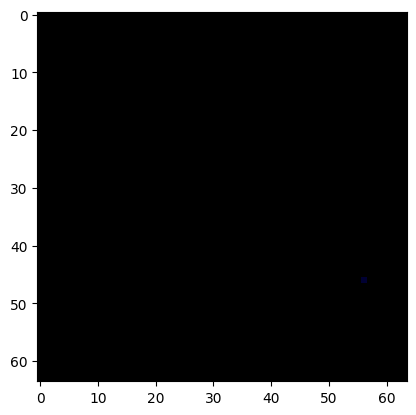

61
tensor(19, device='cuda:0')


In [42]:
out,out1,out2,out3,out4,out5,out6,out7 = SIMBA_single_unt(val_dataset[997][0].cuda(),val_dataset[997][1].cuda(),model.cuda())


plt.imshow(val_dataset[997][0].permute(1,2,0))
plt.show()
out = out.to('cpu')
plt.imshow(out.permute(1,2,0))
plt.show()
# print(iter)
plt.imshow((val_dataset[997][0]-out).permute(1,2,0))
plt.show()
print(out2)
print(out7)

<ipython-input-41-9e46aaf655ba>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x))
<ipython-input-41-9e46aaf655ba>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec))
<ipython-input-41-9e46aaf655ba>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(x))


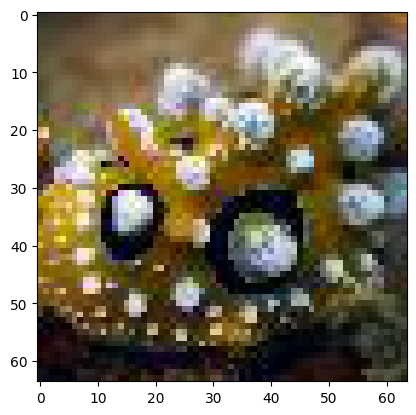

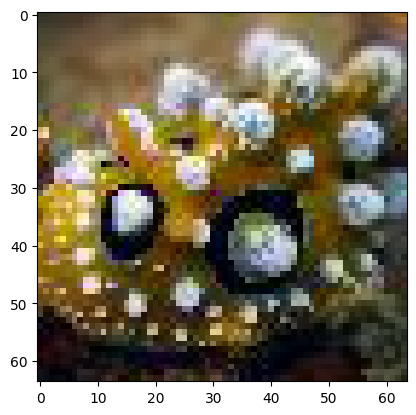

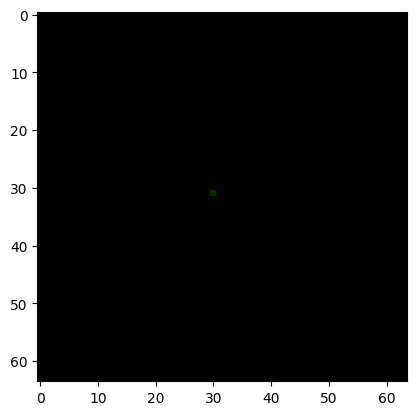

61
tensor(15, device='cuda:0')


In [44]:
out,out1,out2,out3,out4,out5,out6,out7 = SIMBA_single_unt(val_dataset[751][0].cuda(),val_dataset[751][1].cuda(),model.cuda())


plt.imshow(val_dataset[751][0].permute(1,2,0))
plt.show()
out = out.to('cpu')
plt.imshow(out.permute(1,2,0))
plt.show()
# print(iter)
plt.imshow((val_dataset[751][0]-out).permute(1,2,0))
plt.show()
print(out2)
print(out7)

# SIMBA for Targeted

In [36]:
def SIMBA_single_tar(x, y,target, model, epsilon=0.2, num_iters=10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    x = x.unsqueeze(0)
    x_probs = F.softmax(model(x))
    def_prob = x_probs[0][target]

    for i in range(num_iters):
        delta = torch.zeros(n_dims).cuda()
        delta[perm[i]] = epsilon
        add_vec = x + delta.view(x.size())
        probs = F.softmax(model(add_vec))
        new_prob = probs[0][target]

        if new_prob > def_prob:
            x = add_vec
            def_prob = new_prob
        else:
            x = x - delta.view(x.size())
            probs = F.softmax((model(x)))
            def_prob = probs[0][target]

        ad_prob, ad_pred = torch.max(probs,1)

        if ad_pred[0].item()==target:
          break

        # x = x.to(torch.device("cpu"))

        # pred_label = torch.argmax(probs, dim=1).cpu().item()
        # if pred_label == target:
        #     break

    return x.squeeze(), i+1, x_probs[0][y] , probs[0][y], probs[0][target], ad_prob
    # adverse image, number of iterations, initial prob of original class, final prob of original class
    # initial prob of target class, final prob of target class,


In [60]:
image,iter, i_o_c, f_o_c, i_t_c,f_t_c = SIMBA_single_tar(val_dataset[9998][0].cuda(),val_dataset[9998][1].cuda(),torch.tensor(16).cuda(),model.cuda())

<ipython-input-38-f3923dabf9a1>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x))
<ipython-input-38-f3923dabf9a1>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec))
<ipython-input-38-f3923dabf9a1>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax((model(x)))


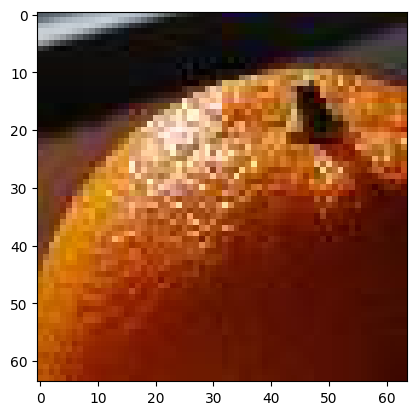

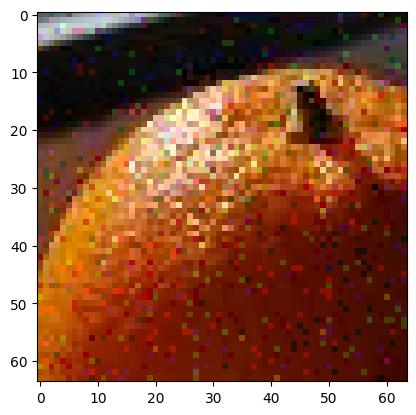

933


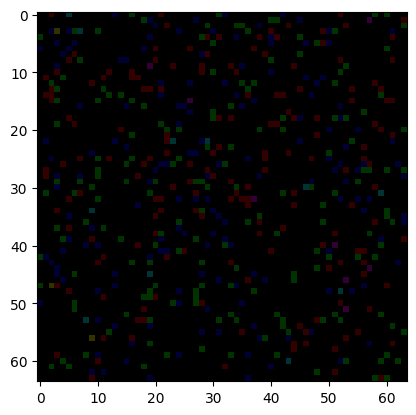

In [61]:
plt.imshow(val_dataset[9998][0].permute(1,2,0))
plt.show()
image = image.to('cpu')
plt.imshow(image.permute(1,2,0))
plt.show()
print(iter)
plt.imshow((val_dataset[9998][0]-image).permute(1,2,0))

<ipython-input-36-f3923dabf9a1>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x))
<ipython-input-36-f3923dabf9a1>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec))
<ipython-input-36-f3923dabf9a1>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax((model(x)))


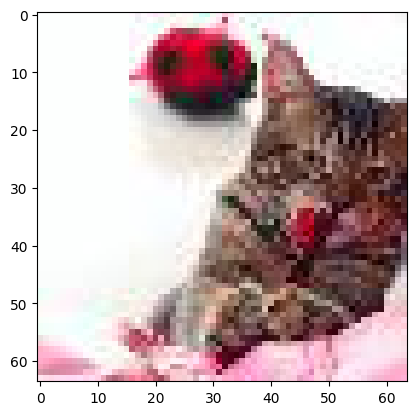

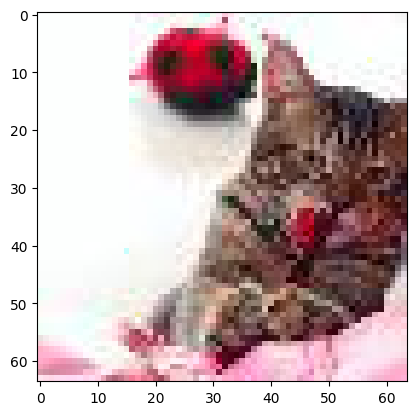

4
tensor(27)


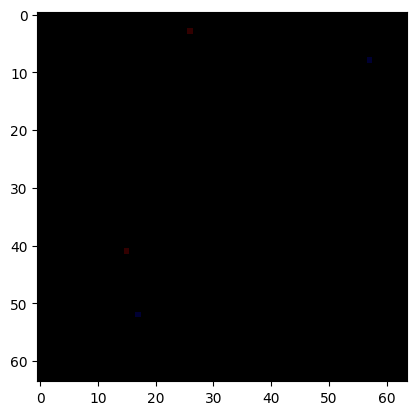

In [39]:
image,iter, i_o_c, f_o_c, i_t_c,f_t_c = SIMBA_single_tar(val_dataset[1369][0].cuda(),val_dataset[1369][1].cuda(),torch.tensor(186).cuda(),model.cuda())


plt.imshow(val_dataset[1369][0].permute(1,2,0))
plt.show()
image = image.to('cpu')
plt.imshow(image.permute(1,2,0))
plt.show()
print(iter)
plt.imshow((val_dataset[1369][0]-image).permute(1,2,0))
print(val_dataset[1369][1])

In [37]:
out = model(val_dataset[1369][0].unsqueeze(0).to(device))
out = F.softmax(out,dim = 1)

# print(out[0].sort()[1])
# print(out)

# val_dataset[0][0].shape

print(out.topk(10,dim=1)[1].squeeze().tolist()[-1])
print(out)

186
tensor([[0.0048, 0.0045, 0.0051, 0.0046, 0.0049, 0.0057, 0.0049, 0.0050, 0.0048,
         0.0056, 0.0044, 0.0048, 0.0060, 0.0048, 0.0041, 0.0041, 0.0055, 0.0053,
         0.0044, 0.0046, 0.0045, 0.0045, 0.0045, 0.0045, 0.0043, 0.0044, 0.0052,
         0.0045, 0.0046, 0.0046, 0.0044, 0.0042, 0.0049, 0.0043, 0.0047, 0.0066,
         0.0041, 0.0048, 0.0046, 0.0046, 0.0038, 0.0039, 0.0049, 0.0047, 0.0050,
         0.0044, 0.0047, 0.0041, 0.0043, 0.0049, 0.0047, 0.0044, 0.0047, 0.0036,
         0.0045, 0.0053, 0.0045, 0.0055, 0.0052, 0.0046, 0.0046, 0.0056, 0.0058,
         0.0045, 0.0043, 0.0042, 0.0064, 0.0052, 0.0048, 0.0052, 0.0054, 0.0064,
         0.0046, 0.0061, 0.0040, 0.0052, 0.0057, 0.0062, 0.0040, 0.0046, 0.0056,
         0.0049, 0.0046, 0.0044, 0.0049, 0.0047, 0.0037, 0.0058, 0.0048, 0.0045,
         0.0049, 0.0055, 0.0047, 0.0049, 0.0052, 0.0050, 0.0047, 0.0054, 0.0063,
         0.0041, 0.0047, 0.0055, 0.0048, 0.0044, 0.0061, 0.0052, 0.0062, 0.0040,
         0.0049, 0.0049,

# SIMBA for Untargeted with DCT

In [22]:
def SIMBA_single_unt_dct(x,y,model,epsilon=0.2,num_iters = 10000):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  n_dims = x.view(1,-1).size(1)
  
  perm = torch.randperm(n_dims)

  x = x.unsqueeze(0)
  x_probs = F.softmax(model(x.to(device)))
  def_prob = x_probs[0][y]

  
  for i in range(num_iters):
    delta = np.zeros(n_dims)

    # convert delta to dct domain
    delta_dct = dct(delta, norm='ortho')
    delta_dct[perm[i]] = epsilon

    # convert x to dct domain
    x_np = x.cpu().numpy()
    x_dct = dct(x_np.reshape((1, -1)), norm='ortho')
    add_vec_dct = x_dct + delta_dct

    # convert back to image domain
    add_vec = idct(add_vec_dct, norm='ortho')
    # convert back to tensor
    add_vec = torch.from_numpy(add_vec.reshape((1, 3, 64, 64))).float()

    # add_vec = x + delta.view(x.size())
    probs = F.softmax(model(add_vec.to(device)))
    new_prob = probs[0][y]


    if new_prob < def_prob:
      x = add_vec
      def_prob = new_prob
    else:
      x_dct = x_dct - delta_dct

      # convert back to image domain
      x = idct(x_dct, norm='ortho')
      # convert back to tensor
      x = torch.from_numpy(x.reshape((1, 3, 64, 64))).float()

      # def_prob = F.softmax(model(x))[0][y]
      probs = F.softmax(model(x.to(device)))
      def_prob = probs[0][y]

    ad_prob, ad_pred = torch.max(probs, 1)

    x = x.to(torch.device("cpu"))
    ad_pred = ad_pred.to(torch.device("cpu"))
    ad_prob = ad_prob.to(torch.device("cpu"))
    x_probs = x_probs.to(torch.device("cpu"))
    probs = probs.to(torch.device("cpu"))
    y = y.to(torch.device("cpu"))


    if ad_pred[0].item()!=y:
      break

  return x.squeeze(), i+1, ad_pred[0].item(),x_probs[0][y],probs[0][y],x_probs[0][ad_pred],ad_prob


In [30]:
out,out1,out2,out3,out4,out5,out6 = SIMBA_single_unt_dct(val_dataset[186][0].cuda(),val_dataset[186][1].cuda(),model.cuda())

<ipython-input-22-62e57408efe1>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x.to(device)))
<ipython-input-22-62e57408efe1>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec.to(device)))


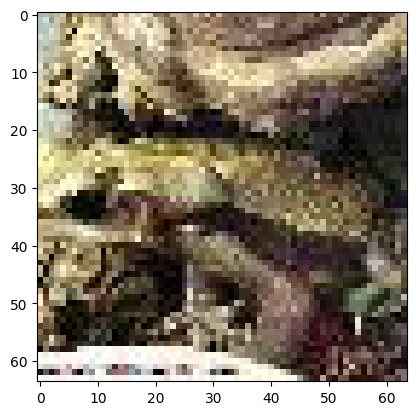

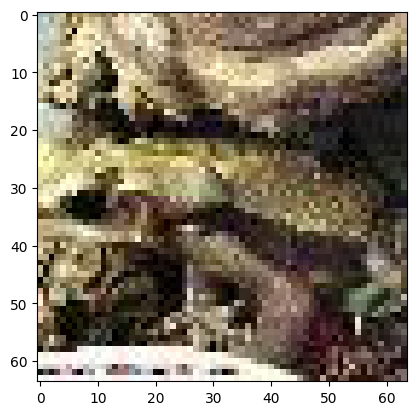

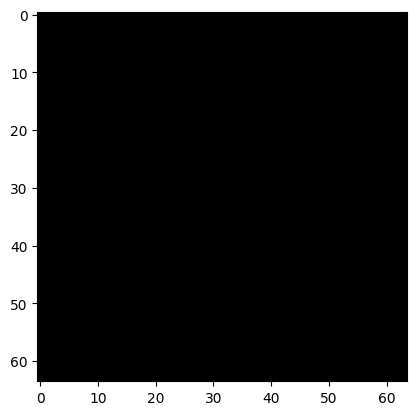

191
tensor(3)


In [31]:
plt.imshow(val_dataset[186][0].permute(1,2,0))
plt.show()
out = out.to('cpu')
plt.imshow(out.permute(1,2,0))
plt.show()
# print(iter)
plt.imshow((val_dataset[186][0]-out).permute(1,2,0))
plt.show()
print(out2)
print(val_dataset[186][1])

<ipython-input-22-62e57408efe1>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x.to(device)))
<ipython-input-22-62e57408efe1>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec.to(device)))


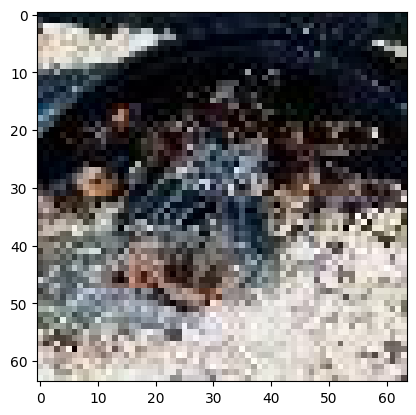

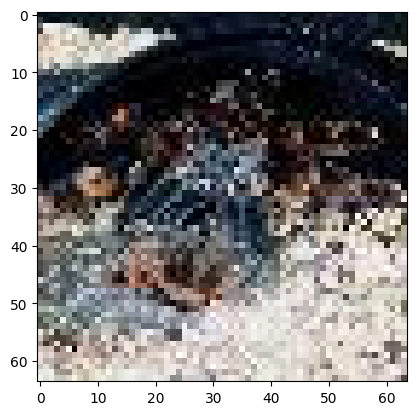

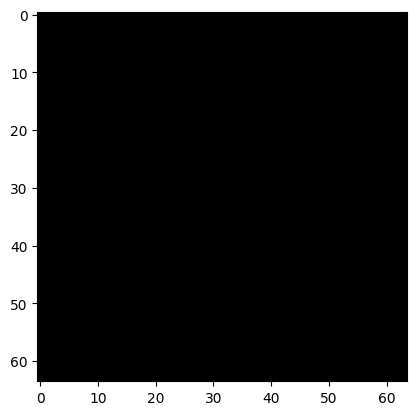

191
tensor(9)


In [34]:
out,out1,out2,out3,out4,out5,out6 = SIMBA_single_unt_dct(val_dataset[459][0].cuda(),val_dataset[459][1].cuda(),model.cuda())

plt.imshow(val_dataset[459][0].permute(1,2,0))
plt.show()
out = out.to('cpu')
plt.imshow(out.permute(1,2,0))
plt.show()
plt.imshow((val_dataset[459][0]-out).permute(1,2,0))
plt.show()
print(out2)
print(val_dataset[459][1])

<ipython-input-22-62e57408efe1>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x.to(device)))
<ipython-input-22-62e57408efe1>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(add_vec.to(device)))
<ipython-input-22-62e57408efe1>:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(model(x.to(device)))


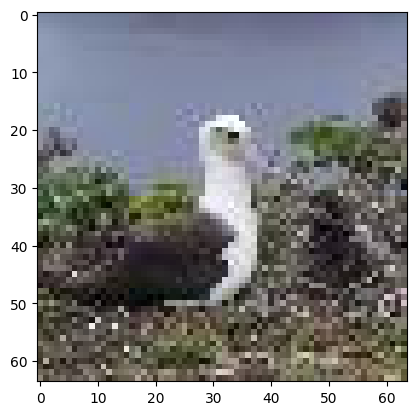

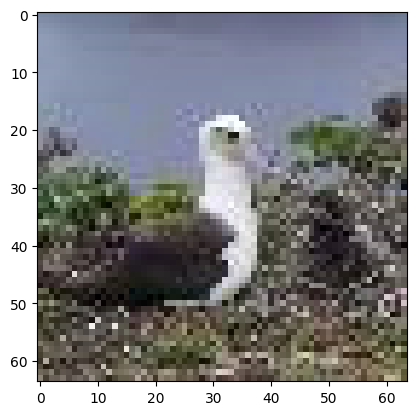

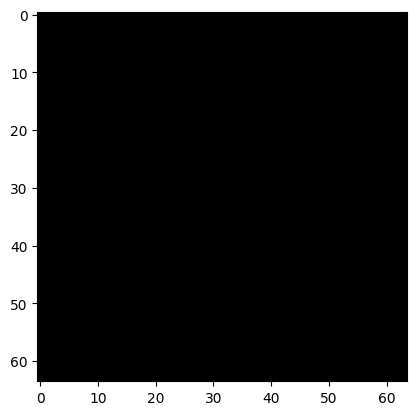

122
tensor(20)


In [35]:
out,out1,out2,out3,out4,out5,out6 = SIMBA_single_unt_dct(val_dataset[1023][0].cuda(),val_dataset[1023][1].cuda(),model.cuda())

plt.imshow(val_dataset[1023][0].permute(1,2,0))
plt.show()
out = out.to('cpu')
plt.imshow(out.permute(1,2,0))
plt.show()
plt.imshow((val_dataset[1023][0]-out).permute(1,2,0))
plt.show()
print(out2)
print(val_dataset[1023][1])